#### Setup

In [26]:
# def 
def vp_KG(K, G, rho):
    return np.sqrt((K + 4./3*G) / rho)
def vs_KG(K, G, rho):
    return np.sqrt(G / rho)
def K_from_vels(vp, vs, rho):
    return rho*(vp**2 - 4/3*vs**2)
def G_from_vels(vs, rho):
    return rho * vs**2
def calc_bounds(ro1, K1, G1, ro2, K2, G2):
    from elasticc.limits import Reuss, Voigt, hs_bounds
    c2 = np.linspace(0,1,1000) # fluid fraction
    c1 = 1 - c2                # solid fraction
    Kr = Reuss(K1,c1,K2,c2)
    Gr = Reuss(G1,c1,G2,c2)
    Kv = Voigt(K1,c1,K2,c2)
    Gv = Voigt(G1,c1,G2,c2)
    Khs1, Ghs1 = hs_bounds(K1,K2,G1,G2,c1,c2)
    Khs2, Ghs2 = hs_bounds(K2,K1,G2,G1,c2,c1)
    K = dict(name='Bulk', v=Kv, r=Kr, hs1=Khs1, hs2=Khs2)
    G = dict(name='Shear', v=Gv, r=Gr, hs1=Ghs1, hs2=Ghs2)
    return c1, c2, K, G
def plot_bounds(ro1, K1, G1, ro2, K2, G2):
    c1, c2, K, G = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    for i, M in enumerate([K,G]): 
        plt.subplot(121+i)
        plt.plot(c2,M['hs1'], label='H-S 1')
        plt.plot(c2,M['hs2'],label='H-S 2')
        plt.fill_between(c2, M['hs1'], M['hs2'], color='w')
        plt.xlabel('Melt fraction')
        plt.ylabel('%s modulus (GPa)' % M['name'])
        plt.xlim(0,1)
        plt.ylim(0,100)
        plt.grid()
        _ = plt.legend()     
def calc(vp_ref=6.2, vpvs=1.73, ro1=2.7, ro2=2.65, 
         a1=1, a2=0.1, K2=12.35, G2=1e-12 ):
    """
    Parameters
    ---------
    vp_ref : float
        In km/s. IMPORTANT
    ro : float
        Density. In g/cm3
    a : float
        Aspect ratio.
    K : float
        Bulk modulus. In GPa.
    G : float
        Shear modulus. In GPa.
    """
    # solid
    vs_ref = vp_ref / vpvs
    K1 =  K_from_vels(vp_ref, vs_ref, ro1)  # GPa 
    G1 =  G_from_vels(vs_ref, ro1)          # GPa 
    # H-S bounds
    c1, c2, K_hs, G_hs = calc_bounds(ro1, K1, G1, ro2, K2, G2)
    roe = Voigt(ro1,c1,ro2,c2)
    vp_hs1 = vp_KG(K_hs['hs1'], G_hs['hs1'], roe)
    vp_hs2 = vp_KG(K_hs['hs2'], G_hs['hs2'], roe)
    # Relaxed, low frequency limit:
    # 1. Calculate dry moduli first (void fill)    
    a, b = vp_hs1, vp_hs2
    K_dry, G_dry = mod_b(K1,0.0,G1,0.0,a1,a2,c1,c2)
    # 2. Then use Gassman's fluid substitution
    K_lo, G_lo = gassman_2(K_dry,G_dry,K1,G1,K2,G2,c2) # NOTE
    vp_lo = vp_KG(K_lo, G_lo, roe)
    return a, b, c2, vp_lo
def get_volume_voxel(dx):
    # dx : float [km]
    # return dV [km3]
    return dx**3
def get_volume_reservoir(A, vp_max=1e8, dx=0.05):
    """
    A : ndarray
    vp_max : float [km/s]
    dx : float [km]
    Return volume : float [km3#
    """
    A = np.array(A)
    dV = get_volume_voxel(dx)
    # number of voxels with vp < vp_max
    n_vox = np.sum((A < vp_max).astype(int))
    return n_vox * dV

In [2]:
# load 
import numpy as np
import matplotlib.pyplot as plt
from arrau.a2d import Arr2d
from arrau.a3d import Arr3d
from elasticc.eep import mod_b, gassman_2
from elasticc.limits import Voigt
from fullwavepy.config.logging import *
from fullwavepy.plot.plt1d import colors
from fullwavepy.project.types.basic import ProjInv
from fullwavepy.seismic.misc import Box3d
from plotea.mpl2d import figure
plt.style.reload_library()
plt.style.use(['default', 'paper2022kolumbo'])
log_lvl(ERROR)
path = '/home/kmc3817/c_projects_phd/fwi_sant_kolumbo/'
geom = {'box': [8000.0, 25000.0, -3000.0, 15000.0, 0, 4000.0],
 'dt': 0.0025,
 'dx': 50,
 'ns': 2000}
p14 = ProjInv('p14', path=path, cat=0, **geom)
b01 = Box3d(8,25, -3,15, 0,4)
b02 = Box3d(8,18,  4,14, 0,4)
svp = Arr3d(p14.o.vp.it[0].read()/1e3, extent=b01.extent).extract(b02.extent)
vp_it = {}
for it in [160]:
    vp_it[it] = Arr3d(p14.o.vp.it[it].read()/1e3, extent=b01.extent).extract(b02.extent)

# V. 01


#### Alg. 
Correct the model for smearing! All the calculation below are done for the corrected model.

In [83]:
# calc
dvp = Arr3d(vp_it[160].arr - svp.arr, extent=b02.extent) # anomaly
nvp = Arr3d(dvp.arr/0.8, extent=b02.extent) # corrected anomaly
cor = Arr3d(svp.arr + nvp.arr, extent=b02.extent) # corrected model

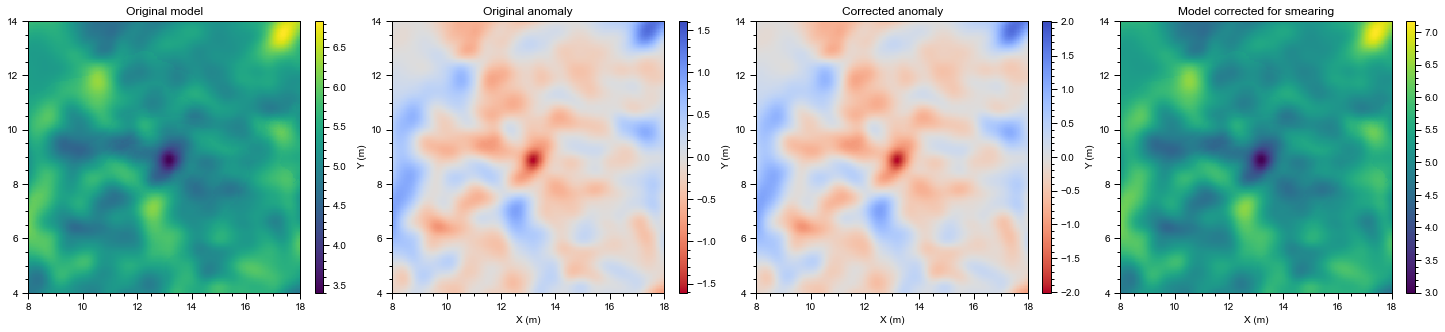

In [84]:
# plot 
kws = dict(value=2.55, unit='km', axis=2)
figure(25,5)
plt.subplot(141)
plt.title('Original model')
vp_it[160].plot(**kws)
plt.subplot(142)
plt.title('Original anomaly')
dvp.plot(**kws, cmap='coolwarm_r', center_cmap=1)
plt.subplot(143)
plt.title('Corrected anomaly')
nvp.plot(**kws, cmap='coolwarm_r', center_cmap=1)
plt.subplot(144)
plt.title('Model corrected for smearing')
cor.plot(**kws)

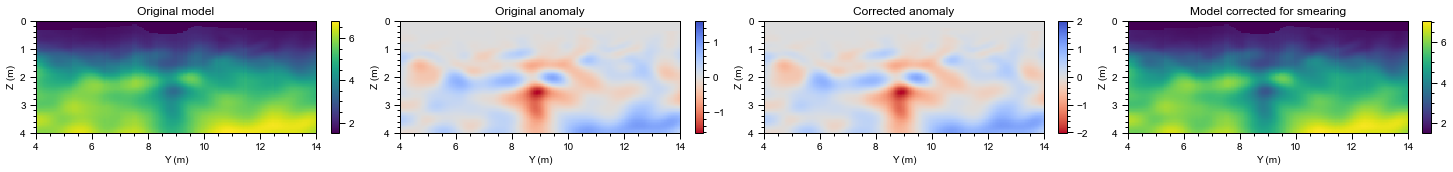

In [85]:
# plot 
kws = dict(value=13.2, unit='km', axis=0)
figure(25,5)
plt.subplot(141)
plt.title('Original model')
vp_it[160].plot(**kws)
plt.subplot(142)
plt.title('Original anomaly')
dvp.plot(**kws, cmap='coolwarm_r', center_cmap=1)
plt.subplot(143)
plt.title('Corrected anomaly')
nvp.plot(**kws, cmap='coolwarm_r', center_cmap=1)
plt.subplot(144)
plt.title('Model corrected for smearing')
cor.plot(**kws)

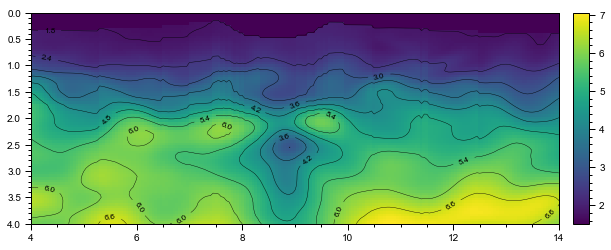

In [92]:
figure(10,5)
cor.plot(**kws, mode='im+cr', show_cntr_labels=1, fontsize=8, fmt='%1.1f',)
plt.gca().invert_yaxis()


#### Alg. 
Prepare $\phi (v_P)$ function 

In [4]:
# calculate 
from scipy import interpolate
vals = [0.05] # we take the middle value of pore-aspect ratio range
hs1, hs2, vp = [], [], []
for i, a2 in enumerate(vals):
    a, b, c2, vp_lo = calc(a2=a2)
    hs1.append(a)
    hs2.append(b)
    vp.append(vp_lo)
vp = vp[0]
# create a 'continuous' function melt_fraction(vp)
vp2melt = interpolate.interp1d(vp, c2)

/home/kmc3817/software/ElasticC/elasticc/eep.py:446: RuntimeWarning: overflow encountered in double_scalars
  A=Gi/G-1.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:447: RuntimeWarning: overflow encountered in double_scalars
  B=(Ki/KK-Gi/G)/3.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:447: RuntimeWarning: invalid value encountered in double_scalars
  B=(Ki/KK-Gi/G)/3.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:472: RuntimeWarning: overflow encountered in double_scalars
  A=Gi/G-1.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:473: RuntimeWarning: overflow encountered in double_scalars
  B=(Ki/KK-Gi/G)/3.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:473: RuntimeWarning: invalid value encountered in double_scalars
  B=(Ki/KK-Gi/G)/3.0
/home/kmc3817/software/ElasticC/elasticc/eep.py:213: RuntimeWarning: invalid value encountered in double_scalars
  nu = 0.5*(3.0*Kd-2.0*Gd)/(3.0*Kd+Gd)
/home/kmc3817/software/ElasticC/elasticc/eep.py:195: RuntimeWarning: invalid val

The max value is 6.2 km/s for which it returns NaN:

In [139]:
vp2melt(6.15), vp2melt(6.2)

(array(0.00309708), array(nan))


#### Alg. 
Extract a (~8 km3, actually it is 41x41x41 volume times 50 m3) subvolume `res` comprising the reservoir denoted in fig02 with a white box

In [43]:
print('Volume of white box: %s km3' % (((41*50)**3)/10**9))

Volume of white box: 8.615125 km3


In [78]:
# x
extent = [[12,14],[7.75,9.75],[2,4]]
res = cor.extract(extent).arr
print('Minimum vp in reservoir is %s km/s' % np.min(res))

Minimum vp in reservoir is 2.9974334 km/s


In [145]:
extent = [[12,14],[7.75,9.75],[2,4]]
print('Before correction %s km/s' % np.min(vp_it[160].extract(extent).arr))

Before correction 3.3996053 km/s



#### Fig. 
Volume occupied by the reservoir as a function of the maximum-Vp boundary. 

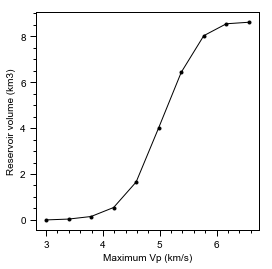

In [79]:
# plot 
def get_volume_voxel(dx):
    # dx : float [km]
    # return dV [km3]
    return dx**3
def get_volume_reservoir(A, vp_max=1e8, dx=0.05):
    """
    A : ndarray
    vp_max : float [km/s]
    dx : float [km]
    Return volume : float [km3#
    """
    A = np.array(A)
    dV = get_volume_voxel(dx)
    # number of voxels with vp < vp_max
    n_vox = np.sum((A < vp_max).astype(int))
    return n_vox * dV
vels = np.linspace(np.min(res), np.max(res), 10)
vols = []
for vp_max in vels:
    vols.append(get_volume_reservoir(res, vp_max=vp_max))
figure(4,4)
plt.plot(vels, vols, 'k.-')
plt.xlabel('Maximum Vp (km/s)')
plt.ylabel('Reservoir volume (km3)')
plt.show()

In [80]:
# E.g.
vp_max = 4.5
print('For %s km/s we get %s km3' % (vp_max, get_volume_reservoir(res, vp_max=vp_max)))

For 4.5 km/s we get 1.2757500000000004 km3



#### Alg. 
Translate Vp into melt fraction for a given aspect ratio. 

In [142]:
extent = [[12,14],[7.75,9.75],[2,4]]
vp_lab = 6.2 # km/s
res_clip = np.clip(res, None, vp_lab-.05) # clip just below the max value from SCS calc.
melt = Arr3d(vp2melt(res_clip), extent=extent)

kws = dict(mode='im+cr', cmap='inferno', vmin=0, vmax=0.6,
           show_cntr_labels=1, fontsize=8, fmt='%1.1f',
           colors='k', linestyles='solid', #levels=np.arange(2.5,6.6, 0.5),
           orientation='horizontal', position='bottom', pad=.6, #fraction=.5,
           label='Melt volume-fraction')

In [5]:
# plot 
figure(4,4)
kwsl = dict(value=13.2, unit='km', axis=0)
melt.plot(**kwsl, **kws)
plt.gca().invert_yaxis()

NameError: name 'melt' is not defined

<Figure size 288x288 with 0 Axes>

In [6]:
# plot 
extent = [[12,14],[7.75,9.75],[2,4]]
vp_lab = 6.2 # km/s
res_clip = np.clip(res, None, vp_lab-.05) # clip just below the max value from SCS calc.
melt = Arr3d(vp2melt(res_clip), extent=extent)

kws = dict(mode='im+cr', cmap='inferno', 
           show_cntr_labels=1, fontsize=8, fmt='%1.1f',
           colors='k', linestyles='solid', #levels=np.arange(2.5,6.6, 0.5),
           orientation='horizontal', position='bottom', pad=.6, #fraction=.5,
           label='Melt volume-fraction')
# figure(4,4)
# kwsl = dict(value=2.55, unit='km', axis=2)
# melt.plot(**kwsl, **kws)
figure(4,4)
kwsl = dict(value=13.2, unit='km', axis=0)
melt.plot(**kwsl, **kws)
plt.gca().invert_yaxis()

NameError: name 'res' is not defined

In [7]:
# plot 
extent = [[12,14],[7.75,9.75],[2,4]]
vp_lab = 6.2 # km/s
res_clip = np.clip(res, None, vp_lab-.05) # clip just below the max value from SCS calc.
melt = Arr3d(vp2melt(res_clip), extent=extent)

kws = dict(mode='im+cr', cmap='inferno', 
           show_cntr_labels=1, fontsize=8, fmt='%1.1f',
           colors='k', linestyles='solid', #levels=np.arange(2.5,6.6, 0.5),
           orientation='horizontal', position='bottom', pad=.6, #fraction=.5,
           label='Melt volume-fraction')
# figure(4,4)
# kwsl = dict(value=2.55, unit='km', axis=2)
# melt.plot(**kwsl, **kws)
figure(4,4)
kwsl = dict(value=13.2, unit='km', axis=0)
melt.plot(**kwsl, **kws)
plt.gca().invert_yaxis()

NameError: name 'res' is not defined


#### Alg. 
Calculate the volume of melt stored in the reservoir. This assumes entire res box is the intrusion. 

For a=0.05

In [144]:
dV = get_volume_voxel(dx=0.05)
Vvox = np.sum(melt.arr)
Vkm3 = Vvox * dV
Vkm3

0.6727731774702942

For a=0.25

In [130]:
dV = get_volume_voxel(dx=0.05)
Vvox = np.sum(melt.arr)
Vkm3 = Vvox * dV
Vkm3

1.440273323675487

For a=0.5

In [135]:
dV = get_volume_voxel(dx=0.05)
Vvox = np.sum(melt.arr)
Vkm3 = Vvox * dV
Vkm3

1.7135196703308564

# V. 02
Automate and account for the irregularity of melt(vp) when calculating sigma.


#### Alg. 
Correct the model for smearing! All the calculation below are done for the corrected model.

In [14]:
# calc
dvp = Arr3d(vp_it[160].arr - svp.arr, extent=b02.extent) # anomaly
nvp = Arr3d(dvp.arr/0.8, extent=b02.extent) # corrected anomaly
cor = Arr3d(svp.arr + nvp.arr, extent=b02.extent) # corrected model

In [13]:
np.min(dvp.arr), np.min(nvp.arr)

(ModelVp(-1.6086879, dtype=float32), ModelVp(-2.0108597, dtype=float32))

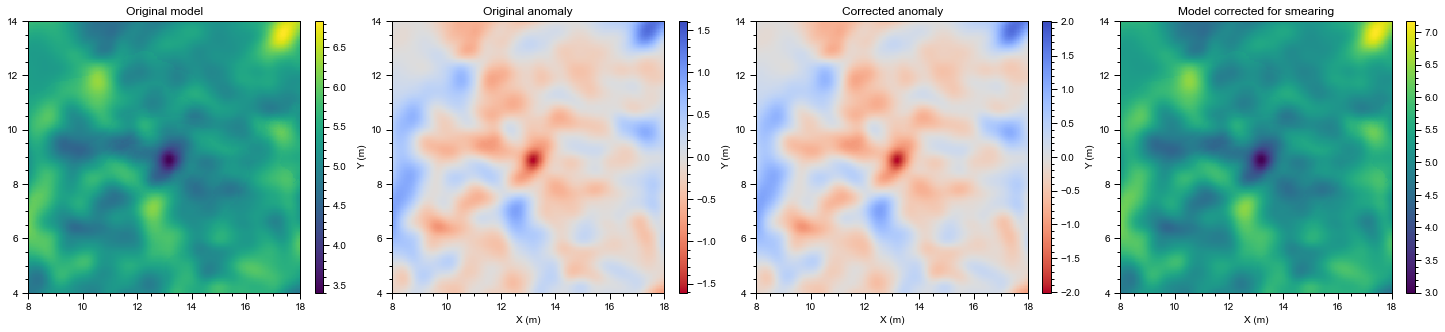

In [84]:
# plot 
kws = dict(value=2.55, unit='km', axis=2)
figure(25,5)
plt.subplot(141)
plt.title('Original model')
vp_it[160].plot(**kws)
plt.subplot(142)
plt.title('Original anomaly')
dvp.plot(**kws, cmap='coolwarm_r', center_cmap=1)
plt.subplot(143)
plt.title('Corrected anomaly')
nvp.plot(**kws, cmap='coolwarm_r', center_cmap=1)
plt.subplot(144)
plt.title('Model corrected for smearing')
cor.plot(**kws)

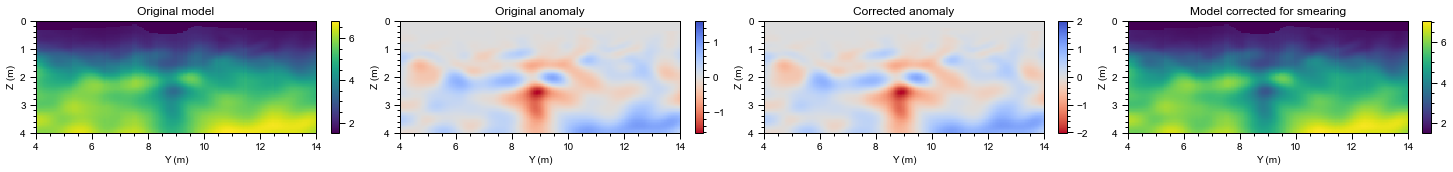

In [85]:
# plot 
kws = dict(value=13.2, unit='km', axis=0)
figure(25,5)
plt.subplot(141)
plt.title('Original model')
vp_it[160].plot(**kws)
plt.subplot(142)
plt.title('Original anomaly')
dvp.plot(**kws, cmap='coolwarm_r', center_cmap=1)
plt.subplot(143)
plt.title('Corrected anomaly')
nvp.plot(**kws, cmap='coolwarm_r', center_cmap=1)
plt.subplot(144)
plt.title('Model corrected for smearing')
cor.plot(**kws)

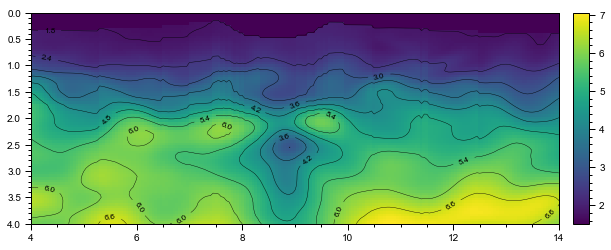

In [92]:
figure(10,5)
cor.plot(**kws, mode='im+cr', show_cntr_labels=1, fontsize=8, fmt='%1.1f',)
plt.gca().invert_yaxis()


#### Alg. 
Prepare $\phi (v_P)$ function 

In [15]:
# calculate 
from scipy import interpolate
vals = np.arange(0.05, 0.51, 0.05) # we take the middle value of pore-aspect ratio range
hs1, hs2, vp = [], [], []
vp2melt = []
for i, a2 in enumerate(vals):
    a, b, c2, vp_lo = calc(a2=a2)
    hs1.append(a)
    hs2.append(b)
    vp.append(vp_lo)
    # create a 'continuous' function melt_fraction(vp)
    vp2melt.append(interpolate.interp1d(vp_lo, c2))

The max value is 6.2 km/s for which it returns NaN:

In [139]:
vp2melt(6.15), vp2melt(6.2)

(array(0.00309708), array(nan))


#### Alg. 
Extract a (~8 km3, actually it is 41x41x41 volume times 50 m3) subvolume `res` comprising the reservoir denoted in fig02 with a white box

In [16]:
# x
extent = [[12,14],[7.75,9.75],[2,4]]
res = cor.extract(extent).arr
print('Minimum vp in reservoir is %s km/s' % np.min(res))

Minimum vp in reservoir is 2.9974334 km/s


In [145]:
extent = [[12,14],[7.75,9.75],[2,4]]
print('Before correction %s km/s' % np.min(vp_it[160].extract(extent).arr))

Before correction 3.3996053 km/s


In [43]:
print('Volume of white box: %s km3' % (((41*50)**3)/10**9))

Volume of white box: 8.615125 km3



#### Fig. 
Volume occupied by the reservoir as a function of the maximum-Vp boundary. 

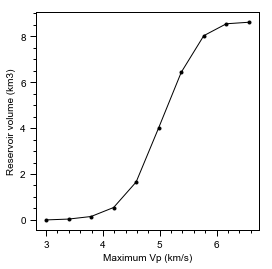

In [79]:
# plot 
vels = np.linspace(np.min(res), np.max(res), 10)
vols = []
for vp_max in vels:
    vols.append(get_volume_reservoir(res, vp_max=vp_max))
figure(4,4)
plt.plot(vels, vols, 'k.-')
plt.xlabel('Maximum Vp (km/s)')
plt.ylabel('Reservoir volume (km3)')
plt.show()

In [80]:
# E.g.
vp_max = 4.5
print('For %s km/s we get %s km3' % (vp_max, get_volume_reservoir(res, vp_max=vp_max)))

For 4.5 km/s we get 1.2757500000000004 km3



#### Alg. 
Translate Vp into melt fraction for a given aspect ratio. 

In [51]:
extent = [[12,14],[7.75,9.75],[2,4]]
vp_lab = 6.2 # km/s
res_clip = np.clip(res, None, vp_lab-.05) # clip just below the max value from SCS calc.
kws = dict(mode='im+cr', cmap='inferno', vmin=0, vmax=0.5,
           show_cntr_labels=1, fontsize=8, fmt='%.2f',
           colors='k', linestyles='solid', #levels=np.arange(2.5,6.6, 0.5),
           orientation='horizontal', position='bottom', pad=.6, #fraction=.5,
           label='Melt volume-fraction')

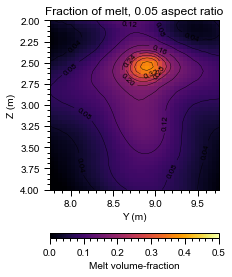

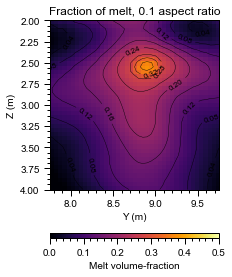

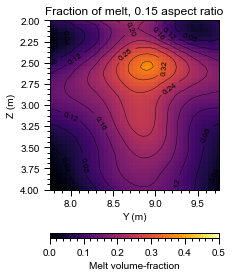

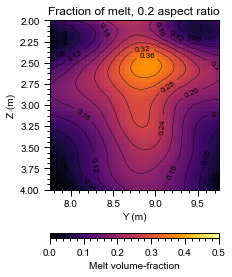

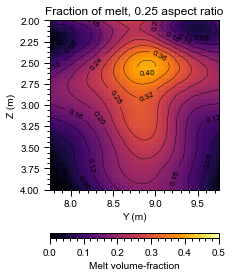

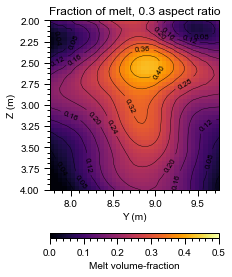

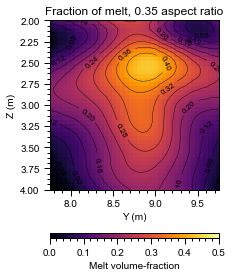

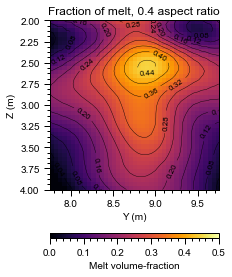

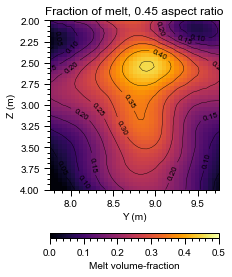

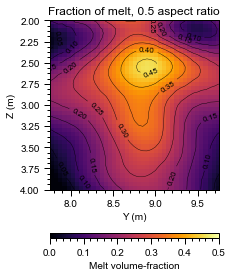

In [52]:
for i, a2 in enumerate(vals):
    melt = Arr3d(vp2melt[i](res_clip), extent=extent)
    figure(4,4)
    plt.title('Fraction of melt, %s aspect ratio' % round(a2,3))
    kwsl = dict(value=13.2, unit='km', axis=0)
    melt.plot(**kwsl, **kws)
    plt.gca().invert_yaxis()    


#### Alg. 
Calculate the volume of melt stored in the reservoir. This assumes entire res box is the intrusion. 

In [31]:
dV = get_volume_voxel(dx=0.05)
vols = []
for i, a2 in enumerate(vals):
    melt = Arr3d(vp2melt[i](res_clip), extent=extent)
    Vvox = np.sum(melt.arr)
    Vkm3 = Vvox * dV
    vols.append(Vkm3)
vol_mean = np.mean(vols)
vol_std = np.std(vols)
print('Volume of reservoir is equal to (%s +/- %s) km3' % (round(vol_mean,2), round(vol_std,2)))

Volume of reservoir is equal to (1.38 +/- 0.32) km3



#### Alg. 
Calculate the volume of **eruptible** melt stored in the reservoir (above critical porosity).

In [53]:
dV = get_volume_voxel(dx=0.05)
vols = []
for i, a2 in enumerate(vals):
    # calculate and plot critical-porosity points
    dif = np.nan_to_num(vp[i] - hs2[i])
    ## index where vp reaches H-S bound (= critical porosity)
    i_c = [i for i in np.where(np.abs(dif)<1e-3)[0] if i > 0 ][0]
    crit_fraction, crit_vp = c2[i_c], vp[i][i_c]
    #print(round(crit_fraction,3))
    melt = Arr3d(vp2melt[i](res_clip), extent=extent)
    # for alpha > 0.15, there is no melt above critical fraction in the reservoir!
    #     print(np.any(melt.arr > crit_fraction))
    erupt = np.where(melt.arr < crit_fraction, 0, melt.arr)
    Vvox = np.sum(erupt)
    Vkm3 = Vvox * dV
    vols.append(Vkm3)    
print(vols)

[0.018811273428442236, 0.0054684347262084505, 0.0011186095001229567, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [58]:
print('Volume of mobile melt: (%s +/- %s) km3)' % (round(np.mean(vols), 4), round(np.std(vols),4)))

Volume of mobile melt: (0.0025 +/- 0.0057) km3)


In [55]:
np.std(vols)

0.00566137456452853

In [50]:
np.max(vp2melt[-1](res_clip))

0.4613758578331853

In [49]:
np.any( > 0.481)

False


#### Alg. 
Calculate magma flux.

In [67]:
t = 2015 - 1650 # yr
print('Time elapsed between the last eruption and data acq.: %s yr' % t)
V = 1.38 # km3
flux = V / t
print('Average magma flux: %s km3/yr' % round(flux,3))
# print('Average magma flux: %s m3/yr' % round(flux*10**9,3))

Time elapsed between the last eruption and data acq.: 365 yr
Average magma flux: 0.004 km3/yr


# ...